In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [41]:
from scipy.special import factorial

def queuing_time( l, m, c):

    rho = l / (c * m)

    k = np.arange(0, c, 1)

    p_0 = 1 / (
        sum([(c * rho) ** k / factorial(k) for k in k]) +
        (c * rho) ** c / (factorial(c) * (1 - rho))
    )

    l_q = (p_0 * (l / m) ** c * rho) / (factorial(c) * (1 - rho))

    w_q = l_q / l

    return w_q

In [222]:
from scipy.stats import norm, rv_histogram

def delay(chargers, n = 10000, arrival = (1, .5)):

    service = 45 * 3.6e6 / 80e3

    # print(service.mean())
    
    arrival = (
        service / (chargers * np.clip(norm(*arrival).rvs(n), .1, np.inf))
    )
    
    return queuing_time(1 / arrival, 1 / service, chargers)

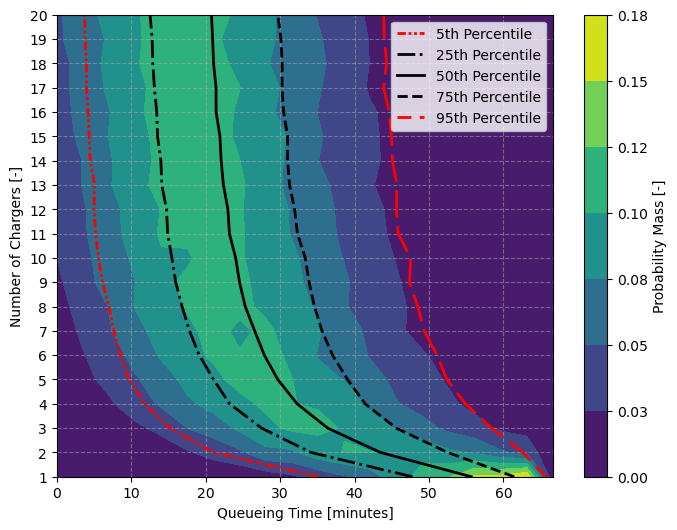

In [304]:
chargers = list(range(1, 21))

bins = np.linspace(0, 3600 + 400, 20)
x = np.linspace(bins[0], bins[-1], 20)

arrival = (2, .5)

h = []

exp_delay = np.zeros((len(chargers), len(x)))
percentiles = np.zeros((5, len(chargers)))

for idx, c in enumerate(chargers):

    h.append(
        rv_histogram(
            np.histogram(
                delay(c, arrival = arrival), bins = bins, density = True
            )
        )
    )

    exp_delay[idx] = h[idx].pdf(x)
    
    percentiles[0, idx] = h[idx].ppf(.05)
    percentiles[1, idx] = h[idx].ppf(.25)
    percentiles[2, idx] = h[idx].ppf(.5)
    percentiles[3, idx] = h[idx].ppf(.75)
    percentiles[4, idx] = h[idx].ppf(.95)

fig, ax  = plt.subplots(1, 1, figsize = (8, 6))

sm = ax.contourf(x / 60, chargers, exp_delay * (bins[1] - bins[0]))
plt.colorbar(sm, ax = ax, label = 'Probability Mass [-]', format = '{x:.2f}')

kw = {
    'color': 'r',
    'lw': 2,
}

plt.plot(
    percentiles[0] / 60, chargers,
    ls = (0, (3, 1, 1, 1, 1, 1)), **kw, label = '5th Percentile'
)

kw['color'] = 'k'

plt.plot(percentiles[1] / 60, chargers, ls = '-.', **kw, label = '25th Percentile')
plt.plot(percentiles[2] / 60, chargers, ls = '-', **kw, label = '50th Percentile')
plt.plot(percentiles[3] / 60, chargers, ls = '--', **kw, label = '75th Percentile')

kw = {
    'color': 'r',
    'lw': 2,
}

kw['color'] = 'r'

plt.plot(percentiles[4] / 60, chargers, ls = (5, (10, 3)), **kw, label = '95th Percentile')


kw = {
    'xlabel': 'Queueing Time [minutes]',
    'ylabel': 'Number of Chargers [-]',
    # 'title': r'Expected Delay for $ARR \in N(2, 0.5)$ by number of Chargers',
    'yticks': range(1, 21),
}

ax.set(**kw)
ax.grid(ls = '--', alpha = .5)
ax.legend()

fig.savefig('Paper/figs/expected_delay_contourf_2.png', bbox_inches = 'tight', dpi = 300)

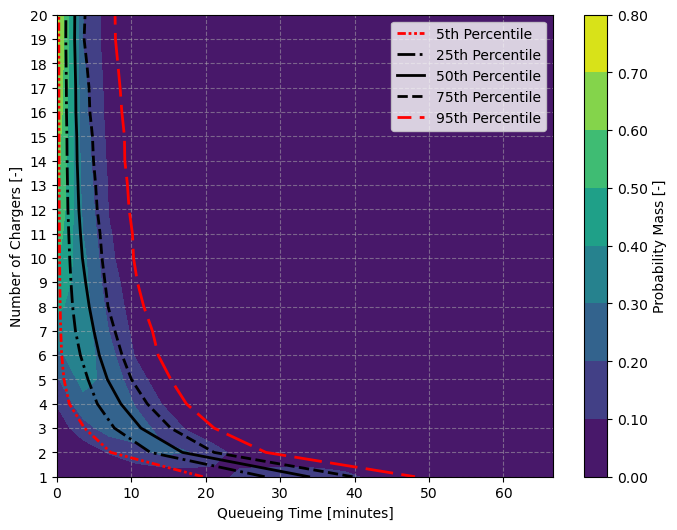

In [305]:
chargers = list(range(1, 21))

bins = np.linspace(0, 3600 + 400, 20)
x = np.linspace(bins[0], bins[-1], 20)

arrival = (1, .25)

h = []

exp_delay = np.zeros((len(chargers), len(x)))
percentiles = np.zeros((5, len(chargers)))

for idx, c in enumerate(chargers):

    h.append(
        rv_histogram(
            np.histogram(
                delay(c, arrival = arrival), bins = bins, density = True
            )
        )
    )

    exp_delay[idx] = h[idx].pdf(x)
    
    percentiles[0, idx] = h[idx].ppf(.05)
    percentiles[1, idx] = h[idx].ppf(.25)
    percentiles[2, idx] = h[idx].ppf(.5)
    percentiles[3, idx] = h[idx].ppf(.75)
    percentiles[4, idx] = h[idx].ppf(.95)

fig, ax  = plt.subplots(1, 1, figsize = (8, 6))

sm = ax.contourf(x / 60, chargers, exp_delay * (bins[1] - bins[0]))
plt.colorbar(sm, ax = ax, label = 'Probability Mass [-]', format = '{x:.2f}')

kw = {
    'color': 'r',
    'lw': 2,
}

plt.plot(
    percentiles[0] / 60, chargers,
    ls = (0, (3, 1, 1, 1, 1, 1)), **kw, label = '5th Percentile'
)

kw['color'] = 'k'

plt.plot(percentiles[1] / 60, chargers, ls = '-.', **kw, label = '25th Percentile')
plt.plot(percentiles[2] / 60, chargers, ls = '-', **kw, label = '50th Percentile')
plt.plot(percentiles[3] / 60, chargers, ls = '--', **kw, label = '75th Percentile')

kw = {
    'color': 'r',
    'lw': 2,
}

kw['color'] = 'r'

plt.plot(percentiles[4] / 60, chargers, ls = (5, (10, 3)), **kw, label = '95th Percentile')


kw = {
    'xlabel': 'Queueing Time [minutes]',
    'ylabel': 'Number of Chargers [-]',
    # 'title': r'Expected Delay for $ARR \in N(1, 0.25)$ by number of Chargers',
    'yticks': range(1, 21),
}

ax.set(**kw)
ax.grid(ls = '--', alpha = .5)
ax.legend()

fig.savefig('Paper/figs/expected_delay_contourf_1.png', bbox_inches = 'tight', dpi = 300)

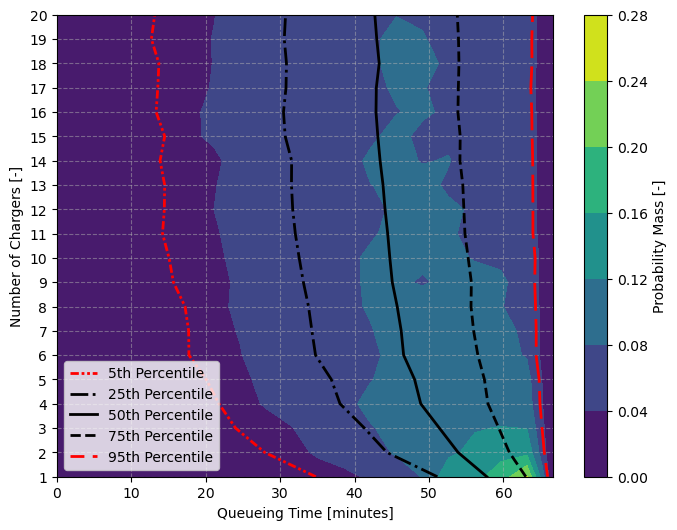

In [306]:
chargers = list(range(1, 21))

bins = np.linspace(0, 3600 + 400, 20)
x = np.linspace(bins[0], bins[-1], 20)

arrival = (3, .75)

h = []

exp_delay = np.zeros((len(chargers), len(x)))
percentiles = np.zeros((5, len(chargers)))

for idx, c in enumerate(chargers):

    h.append(
        rv_histogram(
            np.histogram(
                delay(c, arrival = arrival), bins = bins, density = True
            )
        )
    )

    exp_delay[idx] = h[idx].pdf(x)
    
    percentiles[0, idx] = h[idx].ppf(.05)
    percentiles[1, idx] = h[idx].ppf(.25)
    percentiles[2, idx] = h[idx].ppf(.5)
    percentiles[3, idx] = h[idx].ppf(.75)
    percentiles[4, idx] = h[idx].ppf(.95)

fig, ax  = plt.subplots(1, 1, figsize = (8, 6))

sm = ax.contourf(x / 60, chargers, exp_delay * (bins[1] - bins[0]))
plt.colorbar(sm, ax = ax, label = 'Probability Mass [-]', format = '{x:.2f}')

kw = {
    'color': 'r',
    'lw': 2,
}

plt.plot(
    percentiles[0] / 60, chargers,
    ls = (0, (3, 1, 1, 1, 1, 1)), **kw, label = '5th Percentile'
)

kw['color'] = 'k'

plt.plot(percentiles[1] / 60, chargers, ls = '-.', **kw, label = '25th Percentile')
plt.plot(percentiles[2] / 60, chargers, ls = '-', **kw, label = '50th Percentile')
plt.plot(percentiles[3] / 60, chargers, ls = '--', **kw, label = '75th Percentile')

kw = {
    'color': 'r',
    'lw': 2,
}

kw['color'] = 'r'

plt.plot(percentiles[4] / 60, chargers, ls = (5, (10, 3)), **kw, label = '95th Percentile')


kw = {
    'xlabel': 'Queueing Time [minutes]',
    'ylabel': 'Number of Chargers [-]',
    # 'title': r'Expected Delay for $ARR \in N(3, 0.75)$ by number of Chargers',
    'yticks': range(1, 21),
}

ax.set(**kw)
ax.grid(ls = '--', alpha = .5)
ax.legend()
fig.savefig('Paper/figs/expected_delay_contourf_3.png', bbox_inches = 'tight', dpi = 300)

In [252]:
h[-1].ppf(.5) / 60

20.705659697188175

In [245]:
percentiles / percentiles.sum()

array([[0.1024441 , 0.07997828, 0.06729133, 0.05980561, 0.0543607 ,
        0.05070261, 0.04842322, 0.0471305 , 0.04527537, 0.04407236,
        0.04323821, 0.04199795, 0.04106864, 0.04103341, 0.04014848,
        0.03988974, 0.03913581, 0.03855888, 0.03773291, 0.03771188],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [221]:
deep_reload(src)

kw = {
    'cases': 30,
    'expected_charge_rate': 80e3,
    'service_param': (45 * 3.6e6, 0),
    'chargers': 10,
    'base_delay': 300,
}

station = src.routing.StochasticStation(**kw)
station.expect(src.routing.StochasticVehicle())
station.__dict__, station.delay_time / 3600

({'cases': 30,
  'seed': None,
  'rng': Generator(PCG64) at 0x7FA972C75700,
  'chargers': 10,
  'expected_charge_rate': 80000.0,
  'max_charge_rate': 400000.0,
  'charge_price': 1.3888888888888888e-07,
  'base_delay': 300,
  'arrival_param': (1, 0.5),
  'arrival_limits': (0.1, inf),
  'service_param': (162000000.0, 0),
  'service_limits': (0.1, inf),
  'reliability': 1,
  'energy_price': 1.3888888888888888e-07,
  'functional_chargers': array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
  'at_least_one_functional_charger': True,
  'service': array([2325., 2325., 2325., 2325., 2325., 2325., 2325., 2325., 2325.,
         2325., 2325., 2325., 2325., 2325., 2325., 2325., 2325., 2325.,
         2325., 2325., 2325., 2325., 2325., 2325., 2325., 2325., 2325.,
         2325., 2325., 2325.]),
  'arrival': array([ 568.50266522,  188.49392828,  283.32125821,  168.55240767,
         1041.23378762,  151.20900547,  

In [75]:
class Vehicle():

    def __init__(self, energy):

        self.energy = energy
    
class Station():

    def __init__(self, arrival_prob, charge_rate, chargers):
        
        self.arrival = arrival_prob
        self.charge_rate = charge_rate
        self.chargers = chargers

    def simulate(timesteps):

        queue = []

array([6.34459210e-09, 1.58614803e-08, 6.34459210e-09, 1.26891842e-08,
       2.85506645e-08, 6.02736250e-08, 6.34459210e-08, 1.07858066e-07,
       1.11030362e-07, 1.64959395e-07, 1.93510059e-07, 1.68131691e-07,
       1.64959395e-07, 1.90337763e-07, 3.52124862e-07, 9.83411776e-08,
       1.17374954e-07, 1.01513474e-07, 7.61351052e-08, 1.20547250e-07,
       9.83411776e-08, 1.04685770e-07, 9.83411776e-08, 8.24796973e-08,
       8.56519934e-08, 1.30064138e-07, 1.11030362e-07, 8.24796973e-08,
       1.23719546e-07, 1.01513474e-07, 9.19965855e-08, 1.49097914e-07,
       1.26891842e-07, 1.42753322e-07, 1.17374954e-07, 1.14202658e-07,
       1.30064138e-07, 9.19965855e-08, 1.74476283e-07, 1.68131691e-07,
       1.26891842e-07, 1.77648579e-07, 1.42753322e-07, 9.83411776e-08,
       1.17374954e-07, 1.42753322e-07, 1.07858066e-07, 2.25233020e-07,
       1.64959395e-07, 1.58614803e-07, 1.58614803e-07, 1.58614803e-07,
       1.68131691e-07, 1.71303987e-07, 1.64959395e-07, 1.83993171e-07,
      